In [1]:
!pip install medmnist

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [4]:
from torch.utils.data import DataLoader


# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load datasets (already split)
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)  # Use 'val' instead of splitting
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 89996
Validation samples: 10004
Test samples: 7180


In [5]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/oussama/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC

In [6]:
# visualization

train_dataset.montage(length=1)

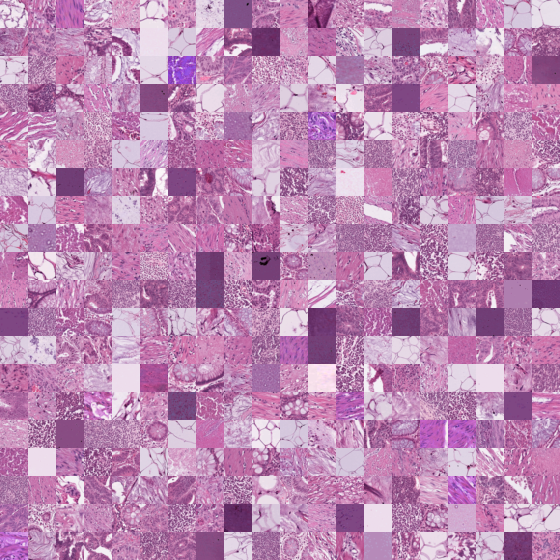

In [7]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [8]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [66]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
class M5(torch.nn.Module):
    def __init__(self, output=9):
        super(M5, self).__init__()
        # Layer 1
        self.Conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.ReLU1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 2
        self.Conv2 = torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.ReLU2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 3
        self.Conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.ReLU3 = nn.ReLU()
        self.AvgPool3 = torch.nn.AvgPool2d(kernel_size = 3)
        self.Flatten = nn.Flatten()
        self.FC1 = torch.nn.Linear(1*1*128, output)


    def forward(self, x):
        out = self.Conv1(x)
        out = self.ReLU1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.ReLU2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.ReLU3(out)
        out = self.AvgPool3(out)
        out = self.Flatten(out)
        out = out.view(out.shape[0], -1)  # Fix flattening
        out = self.FC1(out)
        return out
    
model = M5(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [9]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Store attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Main path
        self.res_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.res_bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.res_relu1 = nn.ReLU()

        self.res_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.res_bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )

        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main path
        out = self.res_conv1(x)
        out = self.res_bn1(out)
        out = self.res_relu1(out)

        out = self.res_conv2(out)
        out = self.res_bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu2(out)
        
        return out
    


class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)  # Normalize activations
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        # output = self.conv2(output)
        # output = self.relu2(output)
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [14]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [15]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 704/704 [00:14<00:00, 49.86it/s]



Summary: Train Loss: 1.2066, Train Acc: 54.22%, Validation Loss: 1.5736, Validation Acc: 57.55%

Epoch [2/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.41it/s]



Summary: Train Loss: 0.8224, Train Acc: 69.07%, Validation Loss: 1.0409, Validation Acc: 72.62%

Epoch [3/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.34it/s]



Summary: Train Loss: 0.6762, Train Acc: 75.41%, Validation Loss: 0.9270, Validation Acc: 75.45%

Epoch [4/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.51it/s]



Summary: Train Loss: 0.5666, Train Acc: 79.63%, Validation Loss: 0.8341, Validation Acc: 77.65%

Epoch [5/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.23it/s]



Summary: Train Loss: 0.4908, Train Acc: 82.61%, Validation Loss: 0.7505, Validation Acc: 79.23%

Epoch [6/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.96it/s]



Summary: Train Loss: 0.4447, Train Acc: 84.31%, Validation Loss: 0.5941, Validation Acc: 84.75%

Epoch [7/100] Training...


100%|██████████| 704/704 [00:13<00:00, 53.73it/s]



Summary: Train Loss: 0.4197, Train Acc: 85.23%, Validation Loss: 0.6181, Validation Acc: 83.65%

Epoch [8/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.33it/s]



Summary: Train Loss: 0.3955, Train Acc: 86.07%, Validation Loss: 0.8723, Validation Acc: 77.13%

Epoch [9/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.21it/s]



Summary: Train Loss: 0.3807, Train Acc: 86.62%, Validation Loss: 0.5911, Validation Acc: 83.79%

Epoch [10/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.68it/s]



Summary: Train Loss: 0.3633, Train Acc: 87.21%, Validation Loss: 0.6577, Validation Acc: 84.04%

Epoch [11/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.03it/s]



Summary: Train Loss: 0.3558, Train Acc: 87.48%, Validation Loss: 0.5312, Validation Acc: 85.73%

Epoch [12/100] Training...


100%|██████████| 704/704 [00:12<00:00, 55.26it/s]



Summary: Train Loss: 0.3418, Train Acc: 88.07%, Validation Loss: 0.4317, Validation Acc: 89.17%

Epoch [13/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.57it/s]



Summary: Train Loss: 0.3333, Train Acc: 88.26%, Validation Loss: 0.4985, Validation Acc: 86.88%

Epoch [14/100] Training...


100%|██████████| 704/704 [00:11<00:00, 58.71it/s]



Summary: Train Loss: 0.3235, Train Acc: 88.56%, Validation Loss: 0.4556, Validation Acc: 88.13%

Epoch [15/100] Training...


100%|██████████| 704/704 [00:13<00:00, 53.47it/s]



Summary: Train Loss: 0.3170, Train Acc: 88.76%, Validation Loss: 0.4772, Validation Acc: 87.53%

Epoch [16/100] Training...


100%|██████████| 704/704 [00:12<00:00, 55.21it/s]



Summary: Train Loss: 0.3098, Train Acc: 89.14%, Validation Loss: 0.3962, Validation Acc: 89.61%

Epoch [17/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.01it/s]



Summary: Train Loss: 0.3006, Train Acc: 89.52%, Validation Loss: 0.4667, Validation Acc: 88.49%

Epoch [18/100] Training...


100%|██████████| 704/704 [00:15<00:00, 46.80it/s]



Summary: Train Loss: 0.2969, Train Acc: 89.60%, Validation Loss: 0.4236, Validation Acc: 89.09%

Epoch [19/100] Training...


100%|██████████| 704/704 [00:14<00:00, 48.77it/s]



Summary: Train Loss: 0.2897, Train Acc: 89.97%, Validation Loss: 0.4058, Validation Acc: 89.47%

Epoch [20/100] Training...


100%|██████████| 704/704 [00:14<00:00, 47.98it/s]



Summary: Train Loss: 0.2834, Train Acc: 89.97%, Validation Loss: 0.4182, Validation Acc: 89.28%

Epoch [21/100] Training...


100%|██████████| 704/704 [00:16<00:00, 42.96it/s]



Summary: Train Loss: 0.2821, Train Acc: 90.11%, Validation Loss: 0.6123, Validation Acc: 82.92%

Epoch [22/100] Training...


100%|██████████| 704/704 [00:17<00:00, 41.31it/s]



Summary: Train Loss: 0.2741, Train Acc: 90.43%, Validation Loss: 0.5253, Validation Acc: 86.53%

Epoch [23/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.94it/s]



Summary: Train Loss: 0.2714, Train Acc: 90.40%, Validation Loss: 0.4795, Validation Acc: 87.28%

Epoch [24/100] Training...


100%|██████████| 704/704 [00:16<00:00, 42.68it/s]



Summary: Train Loss: 0.2669, Train Acc: 90.62%, Validation Loss: 0.5066, Validation Acc: 88.05%

Epoch [25/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.07it/s]



Summary: Train Loss: 0.2620, Train Acc: 90.87%, Validation Loss: 0.5204, Validation Acc: 86.97%

Epoch [26/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.72it/s]



Summary: Train Loss: 0.2571, Train Acc: 90.98%, Validation Loss: 0.4206, Validation Acc: 88.64%

Epoch [27/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.18it/s]



Summary: Train Loss: 0.2579, Train Acc: 91.04%, Validation Loss: 0.4954, Validation Acc: 87.35%

Epoch [28/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.99it/s]



Summary: Train Loss: 0.2616, Train Acc: 90.79%, Validation Loss: 0.6705, Validation Acc: 84.61%

Epoch [29/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.56it/s]



Summary: Train Loss: 0.2531, Train Acc: 91.21%, Validation Loss: 0.3835, Validation Acc: 90.28%

Epoch [30/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.73it/s]



Summary: Train Loss: 0.2451, Train Acc: 91.43%, Validation Loss: 0.3997, Validation Acc: 90.02%

Epoch [31/100] Training...


100%|██████████| 704/704 [00:18<00:00, 39.06it/s]



Summary: Train Loss: 0.2460, Train Acc: 91.35%, Validation Loss: 0.4715, Validation Acc: 87.72%

Epoch [32/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.40it/s]



Summary: Train Loss: 0.2458, Train Acc: 91.34%, Validation Loss: 0.4138, Validation Acc: 88.22%

Epoch [33/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.59it/s]



Summary: Train Loss: 0.2427, Train Acc: 91.55%, Validation Loss: 0.5057, Validation Acc: 86.46%

Epoch [34/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.97it/s]



Summary: Train Loss: 0.2414, Train Acc: 91.62%, Validation Loss: 0.3611, Validation Acc: 90.68%

Epoch [35/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.92it/s]



Summary: Train Loss: 0.2333, Train Acc: 91.82%, Validation Loss: 0.3527, Validation Acc: 90.86%

Epoch [36/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.96it/s]



Summary: Train Loss: 0.2297, Train Acc: 91.92%, Validation Loss: 0.4048, Validation Acc: 89.48%

Epoch [37/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.84it/s]



Summary: Train Loss: 0.2281, Train Acc: 92.02%, Validation Loss: 0.3973, Validation Acc: 90.25%

Epoch [38/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.18it/s]



Summary: Train Loss: 0.2275, Train Acc: 92.00%, Validation Loss: 0.4719, Validation Acc: 87.58%

Epoch [39/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.35it/s]



Summary: Train Loss: 0.2239, Train Acc: 92.11%, Validation Loss: 0.5991, Validation Acc: 85.80%

Epoch [40/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.48it/s]



Summary: Train Loss: 0.2232, Train Acc: 92.22%, Validation Loss: 0.3497, Validation Acc: 90.99%

Epoch [41/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.89it/s]



Summary: Train Loss: 0.2188, Train Acc: 92.37%, Validation Loss: 0.6394, Validation Acc: 85.14%

Epoch [42/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.42it/s]



Summary: Train Loss: 0.2222, Train Acc: 92.29%, Validation Loss: 0.6033, Validation Acc: 87.02%

Epoch [43/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.68it/s]



Summary: Train Loss: 0.2194, Train Acc: 92.33%, Validation Loss: 0.3607, Validation Acc: 90.92%

Epoch [44/100] Training...


100%|██████████| 704/704 [00:16<00:00, 42.02it/s]



Summary: Train Loss: 0.2190, Train Acc: 92.39%, Validation Loss: 0.3180, Validation Acc: 91.86%

Epoch [45/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.50it/s]



Summary: Train Loss: 0.2195, Train Acc: 92.43%, Validation Loss: 0.3263, Validation Acc: 91.79%

Epoch [46/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.18it/s]



Summary: Train Loss: 0.2112, Train Acc: 92.68%, Validation Loss: 0.3068, Validation Acc: 92.42%

Epoch [47/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.70it/s]



Summary: Train Loss: 0.2115, Train Acc: 92.64%, Validation Loss: 0.3452, Validation Acc: 91.12%

Epoch [48/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.83it/s]



Summary: Train Loss: 0.2090, Train Acc: 92.78%, Validation Loss: 0.3682, Validation Acc: 90.53%

Epoch [49/100] Training...


100%|██████████| 704/704 [00:19<00:00, 36.43it/s]



Summary: Train Loss: 0.2092, Train Acc: 92.74%, Validation Loss: 0.3453, Validation Acc: 90.95%

Epoch [50/100] Training...


100%|██████████| 704/704 [00:16<00:00, 42.46it/s]



Summary: Train Loss: 0.2058, Train Acc: 92.80%, Validation Loss: 0.3289, Validation Acc: 91.74%

Epoch [51/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.29it/s]



Summary: Train Loss: 0.2047, Train Acc: 92.82%, Validation Loss: 0.5033, Validation Acc: 87.15%

Epoch [52/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.37it/s]



Summary: Train Loss: 0.2046, Train Acc: 92.82%, Validation Loss: 0.3757, Validation Acc: 90.24%

Epoch [53/100] Training...


100%|██████████| 704/704 [00:16<00:00, 41.46it/s]



Summary: Train Loss: 0.2039, Train Acc: 92.90%, Validation Loss: 0.3101, Validation Acc: 91.94%

Epoch [54/100] Training...


100%|██████████| 704/704 [00:16<00:00, 42.36it/s]



Summary: Train Loss: 0.2043, Train Acc: 92.88%, Validation Loss: 0.3401, Validation Acc: 91.61%

Epoch [55/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.61it/s]



Summary: Train Loss: 0.1993, Train Acc: 93.09%, Validation Loss: 0.3130, Validation Acc: 92.26%

Epoch [56/100] Training...


100%|██████████| 704/704 [00:16<00:00, 43.89it/s]



Summary: Train Loss: 0.1998, Train Acc: 93.02%, Validation Loss: 0.4651, Validation Acc: 88.11%

Epoch [57/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.10it/s]



Summary: Train Loss: 0.1999, Train Acc: 93.05%, Validation Loss: 0.5011, Validation Acc: 87.66%

Epoch [58/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.34it/s]



Summary: Train Loss: 0.1978, Train Acc: 93.09%, Validation Loss: 0.3807, Validation Acc: 90.09%

Epoch [59/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.99it/s]



Summary: Train Loss: 0.1954, Train Acc: 93.15%, Validation Loss: 0.3109, Validation Acc: 92.10%

Epoch [60/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.20it/s]



Summary: Train Loss: 0.1965, Train Acc: 93.14%, Validation Loss: 0.3678, Validation Acc: 90.51%

Epoch [61/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.99it/s]



Summary: Train Loss: 0.1947, Train Acc: 93.26%, Validation Loss: 0.3500, Validation Acc: 91.15%

Epoch [62/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.23it/s]



Summary: Train Loss: 0.1926, Train Acc: 93.33%, Validation Loss: 0.2927, Validation Acc: 92.63%

Epoch [63/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.65it/s]



Summary: Train Loss: 0.1918, Train Acc: 93.25%, Validation Loss: 0.3218, Validation Acc: 91.71%

Epoch [64/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.24it/s]



Summary: Train Loss: 0.1934, Train Acc: 93.17%, Validation Loss: 0.2733, Validation Acc: 93.15%

Epoch [65/100] Training...


100%|██████████| 704/704 [00:17<00:00, 39.79it/s]



Summary: Train Loss: 0.1893, Train Acc: 93.42%, Validation Loss: 0.4244, Validation Acc: 89.24%

Epoch [66/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.85it/s]



Summary: Train Loss: 0.1905, Train Acc: 93.35%, Validation Loss: 0.2904, Validation Acc: 92.54%

Epoch [67/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.79it/s]



Summary: Train Loss: 0.1904, Train Acc: 93.50%, Validation Loss: 0.3758, Validation Acc: 89.82%

Epoch [68/100] Training...


100%|██████████| 704/704 [00:19<00:00, 36.87it/s]



Summary: Train Loss: 0.1942, Train Acc: 93.24%, Validation Loss: 0.3162, Validation Acc: 92.07%

Epoch [69/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.30it/s]



Summary: Train Loss: 0.1921, Train Acc: 93.35%, Validation Loss: 0.2960, Validation Acc: 92.43%

Epoch [70/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.71it/s]



Summary: Train Loss: 0.1873, Train Acc: 93.43%, Validation Loss: 0.2978, Validation Acc: 92.56%

Epoch [71/100] Training...


100%|██████████| 704/704 [00:18<00:00, 38.88it/s]



Summary: Train Loss: 0.1831, Train Acc: 93.64%, Validation Loss: 0.3031, Validation Acc: 92.28%

Epoch [72/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.90it/s]



Summary: Train Loss: 0.1841, Train Acc: 93.51%, Validation Loss: 0.3253, Validation Acc: 91.84%

Epoch [73/100] Training...


100%|██████████| 704/704 [00:18<00:00, 37.89it/s]



Summary: Train Loss: 0.1839, Train Acc: 93.54%, Validation Loss: 0.4051, Validation Acc: 89.87%

Epoch [74/100] Training...


100%|██████████| 704/704 [00:17<00:00, 40.37it/s]



Summary: Train Loss: 0.1827, Train Acc: 93.68%, Validation Loss: 0.3431, Validation Acc: 91.30%

Epoch [75/100] Training...


100%|██████████| 704/704 [00:16<00:00, 41.46it/s]



Summary: Train Loss: 0.1866, Train Acc: 93.57%, Validation Loss: 0.2774, Validation Acc: 93.03%

Epoch [76/100] Training...


100%|██████████| 704/704 [00:16<00:00, 42.89it/s]



Summary: Train Loss: 0.1830, Train Acc: 93.50%, Validation Loss: 0.3175, Validation Acc: 91.96%

Epoch [77/100] Training...


100%|██████████| 704/704 [00:16<00:00, 43.26it/s]



Summary: Train Loss: 0.1791, Train Acc: 93.75%, Validation Loss: 0.4255, Validation Acc: 89.71%

Epoch [78/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.42it/s]



Summary: Train Loss: 0.1806, Train Acc: 93.70%, Validation Loss: 0.3271, Validation Acc: 91.83%

Epoch [79/100] Training...


100%|██████████| 704/704 [00:13<00:00, 53.19it/s]



Summary: Train Loss: 0.1802, Train Acc: 93.69%, Validation Loss: 0.4132, Validation Acc: 89.78%

Epoch [80/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.32it/s]



Summary: Train Loss: 0.1794, Train Acc: 93.67%, Validation Loss: 0.3200, Validation Acc: 91.76%

Epoch [81/100] Training...


100%|██████████| 704/704 [00:13<00:00, 54.03it/s]



Summary: Train Loss: 0.1771, Train Acc: 93.79%, Validation Loss: 0.3086, Validation Acc: 92.09%

Epoch [82/100] Training...


100%|██████████| 704/704 [00:12<00:00, 55.16it/s]



Summary: Train Loss: 0.1762, Train Acc: 93.88%, Validation Loss: 0.3057, Validation Acc: 92.15%

Epoch [83/100] Training...


100%|██████████| 704/704 [00:12<00:00, 55.74it/s]



Summary: Train Loss: 0.1754, Train Acc: 93.85%, Validation Loss: 0.3085, Validation Acc: 92.08%

Epoch [84/100] Training...


100%|██████████| 704/704 [00:12<00:00, 55.32it/s]



Summary: Train Loss: 0.1750, Train Acc: 93.88%, Validation Loss: 0.3253, Validation Acc: 92.18%

Epoch [85/100] Training...


100%|██████████| 704/704 [00:12<00:00, 55.34it/s]



Summary: Train Loss: 0.1772, Train Acc: 93.72%, Validation Loss: 0.3637, Validation Acc: 90.66%

Epoch [86/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.99it/s]



Summary: Train Loss: 0.1745, Train Acc: 93.92%, Validation Loss: 0.2943, Validation Acc: 92.58%

Epoch [87/100] Training...


100%|██████████| 704/704 [00:13<00:00, 54.11it/s]



Summary: Train Loss: 0.1743, Train Acc: 93.90%, Validation Loss: 0.3280, Validation Acc: 91.59%

Epoch [88/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.81it/s]



Summary: Train Loss: 0.1748, Train Acc: 93.85%, Validation Loss: 0.2886, Validation Acc: 92.46%

Epoch [89/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.60it/s]



Summary: Train Loss: 0.1726, Train Acc: 93.97%, Validation Loss: 0.2802, Validation Acc: 92.94%

Epoch [90/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.90it/s]



Summary: Train Loss: 0.1722, Train Acc: 93.92%, Validation Loss: 0.2927, Validation Acc: 92.52%

Epoch [91/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.82it/s]



Summary: Train Loss: 0.1705, Train Acc: 94.10%, Validation Loss: 0.3806, Validation Acc: 90.65%

Epoch [92/100] Training...


100%|██████████| 704/704 [00:13<00:00, 53.42it/s]



Summary: Train Loss: 0.1737, Train Acc: 93.97%, Validation Loss: 0.2645, Validation Acc: 93.31%

Epoch [93/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.88it/s]



Summary: Train Loss: 0.1719, Train Acc: 94.00%, Validation Loss: 0.4062, Validation Acc: 89.66%

Epoch [94/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.94it/s]



Summary: Train Loss: 0.1709, Train Acc: 94.00%, Validation Loss: 0.3152, Validation Acc: 92.08%

Epoch [95/100] Training...


100%|██████████| 704/704 [00:13<00:00, 53.09it/s]



Summary: Train Loss: 0.1690, Train Acc: 94.02%, Validation Loss: 0.3826, Validation Acc: 90.25%

Epoch [96/100] Training...


100%|██████████| 704/704 [00:12<00:00, 54.78it/s]



Summary: Train Loss: 0.1706, Train Acc: 93.99%, Validation Loss: 0.2719, Validation Acc: 93.30%

Epoch [97/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.59it/s]



Summary: Train Loss: 0.1681, Train Acc: 94.13%, Validation Loss: 0.3562, Validation Acc: 91.10%

Epoch [98/100] Training...


100%|██████████| 704/704 [00:13<00:00, 52.65it/s]



Summary: Train Loss: 0.1735, Train Acc: 93.92%, Validation Loss: 0.3108, Validation Acc: 92.16%

Epoch [99/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.66it/s]



Summary: Train Loss: 0.1684, Train Acc: 94.10%, Validation Loss: 0.2961, Validation Acc: 92.47%

Epoch [100/100] Training...


100%|██████████| 704/704 [00:13<00:00, 51.68it/s]



Summary: Train Loss: 0.1632, Train Acc: 94.30%, Validation Loss: 0.3331, Validation Acc: 91.83%


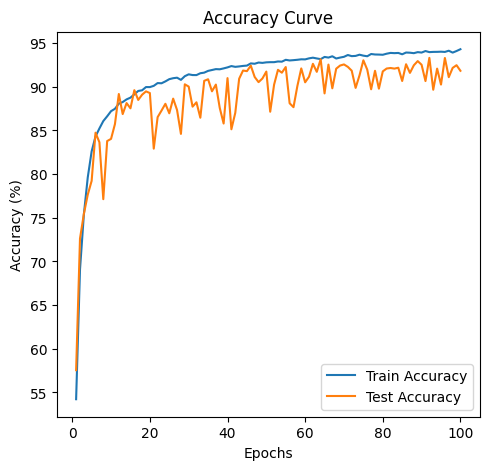

In [16]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [18]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")



Testing the model on the test dataset...

Final Test Results: Loss: 0.7373, Accuracy: 81.13%


# old accuracy 72.01%

In [20]:
#input example
dummy_input = torch.randn(1, 3, 28, 28)

# Define the ONNX file path
onnx_path = "../ONNXModels/pathologie.onnx"

model.to("cpu")
# Export model to ONNX
torch.onnx.export(
    model,                        # Model to export
    dummy_input,                   # Example input
    onnx_path,                     # File path
    export_params=True,             # Store trained parameters
    # training=torch.onnx.TrainingMode.TRAINING,
    opset_version=11,               # ONNX version (11 is widely supported)
    do_constant_folding=True,       # Optimize constant folding
    input_names=["input"],          # Input tensor name
    output_names=["output"],        # Output tensor name
    dynamic_axes={                  # Support variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, nn.BatchNorm2d):
        print(f"Layer: {name}")
        print(f"  Gamma (weight): {module.weight.data}")
        print(f"  Beta (bias): {module.bias.data}")
        print(f"  Running Mean: {module.running_mean}")
        print(f"  Running Variance: {module.running_var}\n")
        print('num_features: ', module.num_features)

Layer: layer1.1
  Gamma (weight): tensor([0.9963, 1.0064, 0.9779, 1.0622, 0.9740, 0.9753, 1.0098, 1.0000, 0.9805,
        0.9786, 1.0194, 1.0472, 0.9717, 0.9655, 1.0228, 0.9964],
       device='cuda:0')
  Beta (bias): tensor([ 0.0440, -0.0052, -0.0076,  0.0355,  0.0136,  0.0051,  0.0175, -0.0019,
        -0.0499, -0.0116,  0.0320,  0.0816,  0.0985, -0.0044,  0.0554,  0.0017],
       device='cuda:0')
  Running Mean: tensor([ 0.4135, -0.2543,  0.1491,  0.0673, -0.0612,  0.0082, -0.1279,  0.0807,
        -0.1603,  0.1105, -0.0274, -0.1849,  0.4404, -0.3070,  0.2839,  0.1630],
       device='cuda:0')
  Running Variance: tensor([0.0213, 0.0128, 0.0123, 0.0121, 0.0146, 0.0150, 0.0042, 0.0056, 0.0118,
        0.0165, 0.0034, 0.0067, 0.0096, 0.0239, 0.0084, 0.0180],
       device='cuda:0')

Layer: layer2.1
  Gamma (weight): tensor([1.0175, 0.9955, 0.9999, 0.9991, 1.0218, 0.9770, 1.0066, 0.9992, 0.9854,
        0.9958, 0.9648, 1.0138, 1.0139, 0.9951, 1.0074, 1.0059],
       device='cuda:0')
  B

# We then check a 2D dataset with size 224x224

In [ ]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/pathmnist_224.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


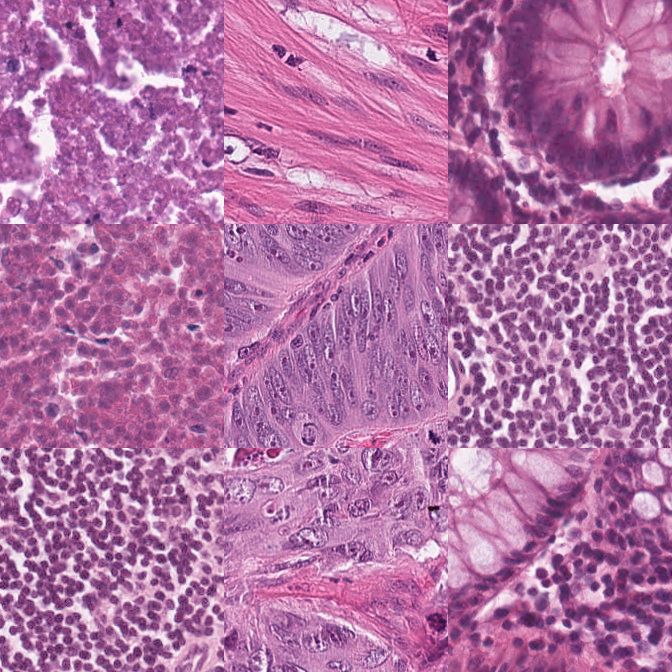

In [ ]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [ ]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).cuda()

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        targets = targets.cuda()
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [02:39<00:00,  4.41it/s]


In [ ]:
split = 'test'

model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = validation_loader if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

test  auc: 0.760  acc: 0.277


# We then check a 3D dataset with size 28x28x28

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [ ]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

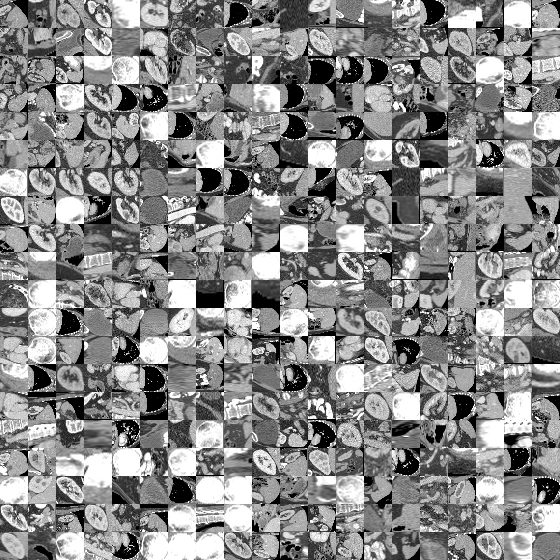

In [ ]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# We then check a 3D dataset with size 64x64x64

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d_64.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


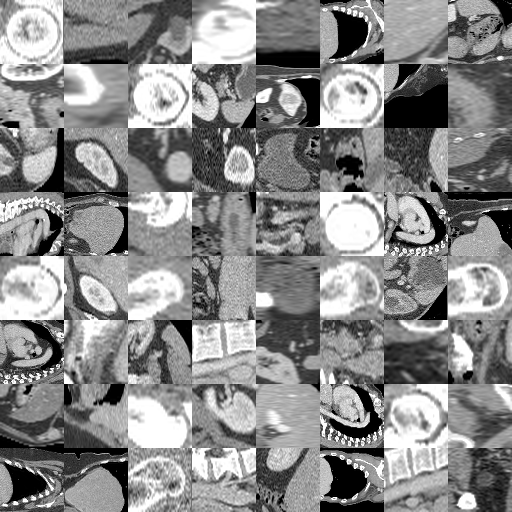

In [ ]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)